# A "coin" flipping example

Originally part of a midterm review lesson for psychology 101D ("Data Science for Research Psychology") at UC Berkeley, Fall 2019

* **Scenario**: I have some of these furniture movers, they look like hockey pucks:

![furniture](img/furniture_mover_small.jpeg)

* **Research question:** would these be "fair" coins?
  * They're not symmetrical (one side is foam, the other felt). But maybe they're balanced anyway?
  * If they're imbalanced, but only *I* know how they are imbalanced, maybe I can win money betting against my friends...
* **Procedure:**
  * I brought in 5 of these. Each "coin" was tossed 10 times by a group of students, yielding 50 total values.
* **Solution:**
  * The rest of this notebook has these data and our statistical tests using pyMC.
  * We conclude that these coins are _probably not_ fair, and are 95% sure that the true chance of the white (felt) side landing face-up is in the range (0.49 - 0.73)
* **Questions to ponder**
  * How much did our choice of prior matter? Why?
  * Try changing the data and see how the priors behave.
    * What happens when you have 500 instead of 50 observations? (You can do this by adding `*10` to the end of the `DATA` array definition)
    * What if you only have 5? 1?
    * Do priors matter more when there are more or fewer observations

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

<div style="background-color: #A33;height: 20px"></div>

## Import and setup code -- no need to read this, it's not magic but it helps things look nice

In [1]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

Everett Wetchler 2019-10-29 22:22:40 PDT 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.2
pandas 0.25.1
matplotlib 3.1.1
seaborn 0.9.0
watermark 2.0.1


In [3]:
import pymc3 as pm
import utils.pymc_utils_frye as shared_util

<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## BEFORE we even gather data, let's write our model code and pick a prior

* Model:
  * We are treating this disc as a coin. Hence, it is a Bernoulli random variable with... an unknown parameter
```python
with pm.Model() as coin_model:
        heads = pm.Bernoulli('heads', p=???)
```
* We know the coin must come up "heads" (white side up) with probability between 0 and 1, so the parameter must always fall between 0 and 1.
  * So... [Uniform](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Uniform)(0, 1) seems like an okay choice.
* It's probably more likely to be near the middle (0.5) than the extremes (0 or 1)
  * Hmm... well, Normal(0.5, something) would work, but it allows values < 0 and > 1. BoundedNormal, however, lets us cut of the "crust" and just keep the part of the Normal thats between 0 and 1. So that's an option.
  * A simple one is a [Trianglular](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Triangular), peaking at 0.5, annd dropping to 0 on both sides (at 0 and 1).

We'll go with **Triangular**, but also later we'll try Uniform to see how much it matters.

In [4]:
with pm.Model() as coin_model_prior_only:
    coin_weight = pm.Triangular('coin_weight', lower=0, upper=1)
    heads = pm.Bernoulli('heads', p=coin_weight)

### We can visualize our prior with `sample_prior_predictive`

In [5]:
with coin_model_prior_only:
    df_prior = shared_util.samples_to_dataframe(
        pm.sample_prior_predictive(100000))

df_prior.head()

,heads,coin_weight,coin_weight_interval__
0,1,0.855865,1.781365
1,1,0.468218,-0.127298
2,1,0.492081,-0.031678
3,0,0.519430,0.077759
4,1,0.411521,-0.357683


### Some pretty plotting code

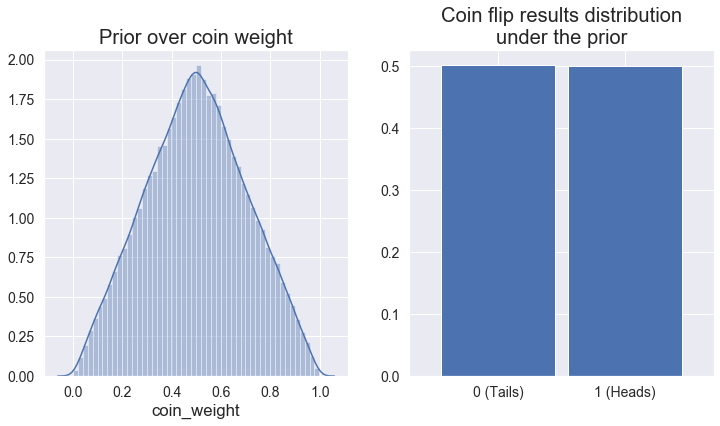

In [6]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

ax = axes[0]
sns.distplot(df_prior['coin_weight'], ax=ax)
ax.set_title('Prior over coin weight')

ax = axes[1]
df_prior['heads'].value_counts(True).plot(kind='bar', width=0.9, ax=ax)
ax.set_title('Coin flip results distribution\nunder the prior')
ax.set_xticklabels(['0 (Tails)', '1 (Heads)'], rotation=0);

<div style="background-color: #A33;height: 20px"></div>

## Data input!

In [7]:
# Students made a total of 50 coin flips, entered below:

DATA = [
    1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
    1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
]

In [8]:
# Quick summary:
pd.Series(DATA).value_counts()

1    31
0    19
dtype: int64

### Same model, only including our observed data

In [9]:
with pm.Model() as coin_model_triangle:
    coin_weight = pm.Triangular('coin_weight', lower=0, upper=1)
    heads = pm.Bernoulli('heads', p=coin_weight, observed=DATA)

### If we `sample_prior_predictive`, we get... the same result! Since we are only looking at the *prior* and ignoring any observed data

In [10]:
with coin_model_triangle:
    df_prior_triangle = shared_util.samples_to_dataframe(
        pm.sample_prior_predictive(10000))

Text(0.5, 1.0, 'Prior over coin weight')

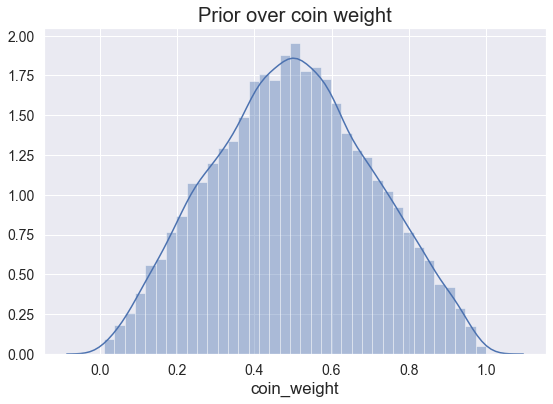

In [11]:
sns.distplot(df_prior_triangle['coin_weight'])
plt.gca().set_title('Prior over coin weight')

## Now let's use `sample()` to learn about our parameter, p

In [12]:
with coin_model_triangle:
    trace = pm.sample(10000)  # 'trace' will be useful later
    df_posterior_triangle = shared_util.samples_to_dataframe(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coin_weight]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:07<00:00, 2646.48draws/s]


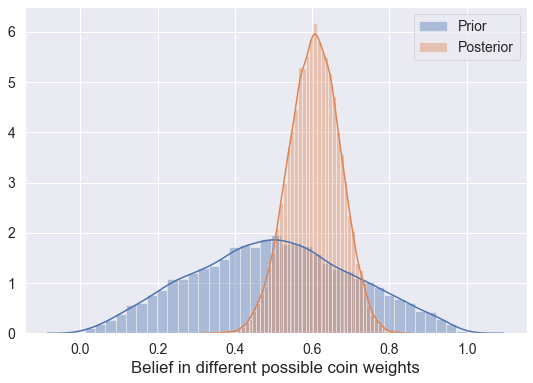

In [13]:
sns.distplot(df_prior_triangle['coin_weight'], label='Prior')
sns.distplot(df_posterior_triangle['coin_weight'], label='Posterior')
plt.gca().set_xlabel('Belief in different possible coin weights')
plt.legend()

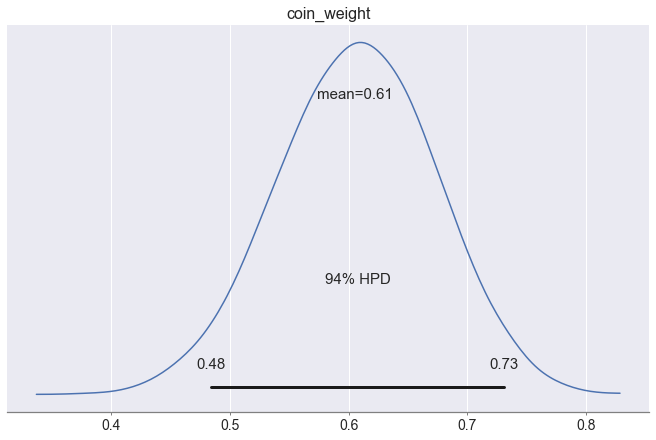

In [14]:
with coin_model_triangle:
    pm.plot_posterior(trace)

### What if we want to use our new knowledge to simulate MORE coin flips?
### `sample_posterior_predictive()`

In [15]:
with coin_model_triangle:
    trace = pm.sample(10000)  # We need the output from sample() to run sample_posterior_predictive()
    sample = pm.sample_posterior_predictive(trace)
    df_posterior_predictions_triangle = shared_util.samples_to_dataframe(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coin_weight]
100%|██████████| 20000/20000 [00:08<00:00, 2437.39it/s]


In [16]:
df_posterior_predictions_triangle.head()

,heads
0,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, ..."
1,"[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ..."
2,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ..."
3,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,"[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, ..."


In [17]:
means = df_posterior_predictions_triangle['heads'].apply(np.mean)
print(f"Posterior coin has an effective weight of {np.mean(means):.3f} towards heads")

Posterior coin has an effective weight of 0.604 towards heads


## What if we'd used "uniform" instead of "triangular"?

In [18]:
with pm.Model() as coin_model_uniform:
    coin_weight = pm.Uniform('coin_weight', lower=0, upper=1)
    heads = pm.Bernoulli('heads', p=coin_weight, observed=DATA)
    
    samples = pm.sample_prior_predictive(100000)
    df_prior_uniform = shared_util.samples_to_dataframe(samples)

    trace = pm.sample(10000)
    df_posterior_uniform = shared_util.samples_to_dataframe(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coin_weight]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:07<00:00, 2717.89draws/s]


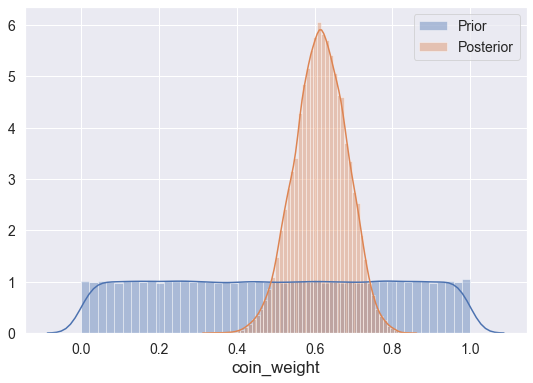

In [19]:
sns.distplot(df_prior_uniform['coin_weight'], label='Prior')
sns.distplot(df_posterior_uniform['coin_weight'], label='Posterior')
plt.legend()

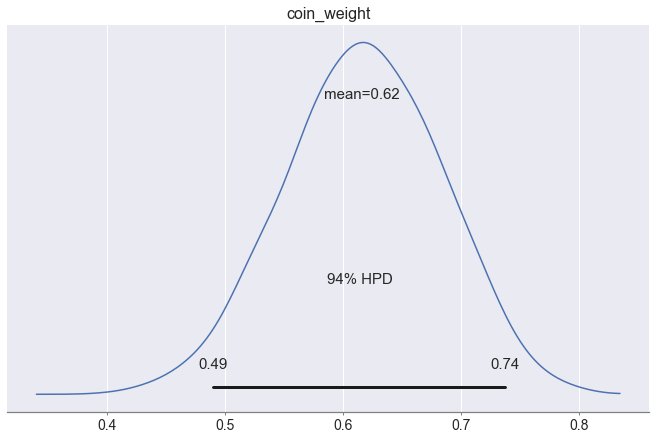

In [20]:
with coin_model_uniform:
    z = pm.plot_posterior(trace)

## A grid of plots to directly compare Uniform and Triangular

Text(0.5, 1.0, 'Comparison of priors')

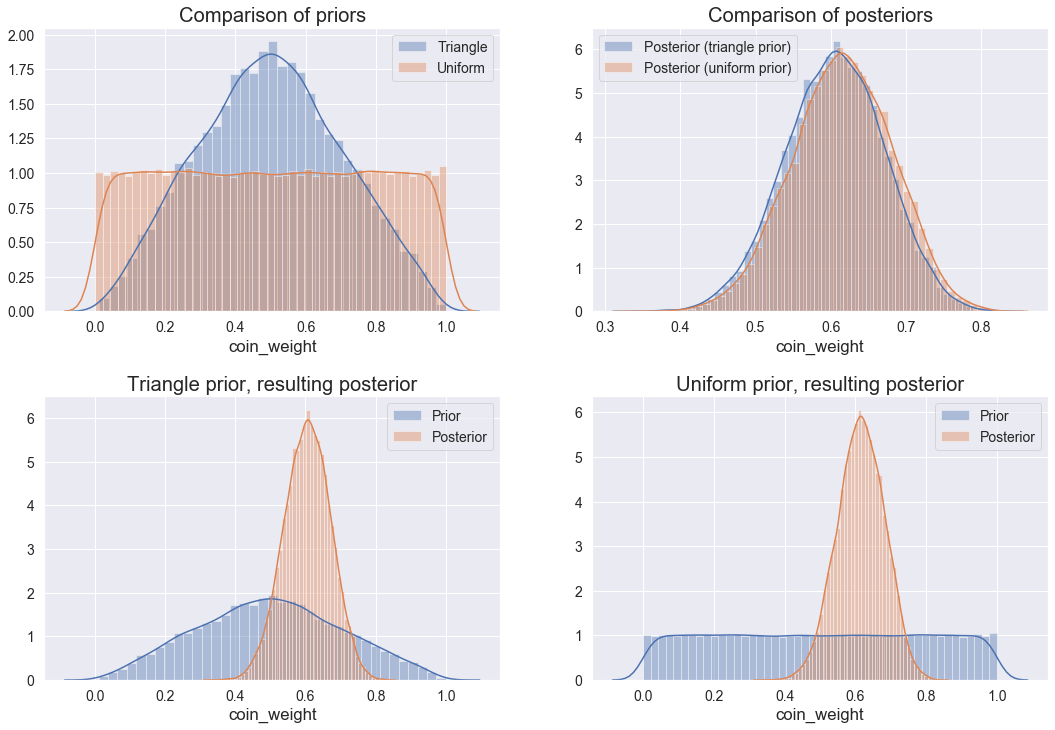

In [21]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
fig.set_size_inches(18, 12)
plt.subplots_adjust(hspace=.3)

ax=axes[2]
sns.distplot(df_prior_triangle['coin_weight'], label='Prior', ax=ax)
sns.distplot(df_posterior_triangle['coin_weight'], label='Posterior', ax=ax)
ax.legend()
ax.set_title('Triangle prior, resulting posterior')

ax=axes[3]
sns.distplot(df_prior_uniform['coin_weight'], label='Prior', ax=ax)
sns.distplot(df_posterior_uniform['coin_weight'], label='Posterior', ax=ax)
ax.legend()
ax.set_title('Uniform prior, resulting posterior')

ax=axes[1]
sns.distplot(df_posterior_triangle['coin_weight'], label='Posterior (triangle prior)', ax=ax)
sns.distplot(df_posterior_uniform['coin_weight'], label='Posterior (uniform prior)', ax=ax)
ax.legend()
ax.set_title('Comparison of posteriors')

ax=axes[0]
sns.distplot(df_prior_triangle['coin_weight'], label='Triangle', ax=ax)
sns.distplot(df_prior_uniform['coin_weight'], label='Uniform', ax=ax)
ax.legend()
ax.set_title('Comparison of priors')